# **EEE3094S LAB 2**
## Nyiko Mathebula
## MTHNYI011



---

#  **System Identification**

## **Step Response Analysis**

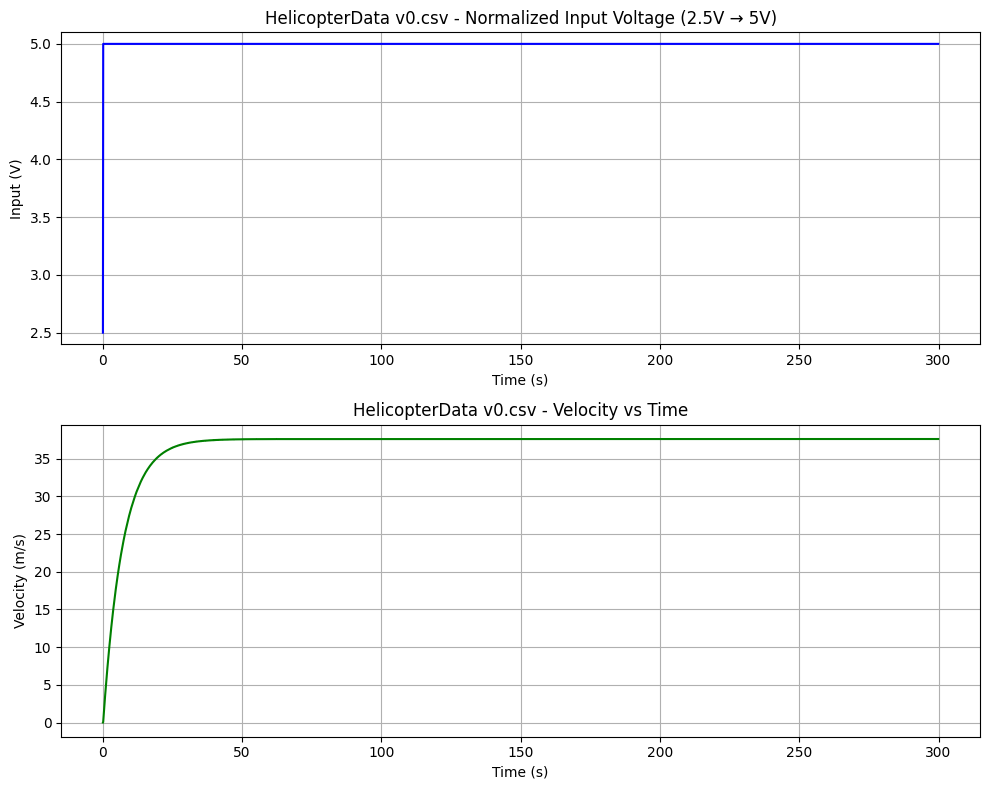

HelicopterData v0.csv:
  System Gain (A) = 15.0440 (m/s per V)
  Time Constant (τ) = 7.3000 s



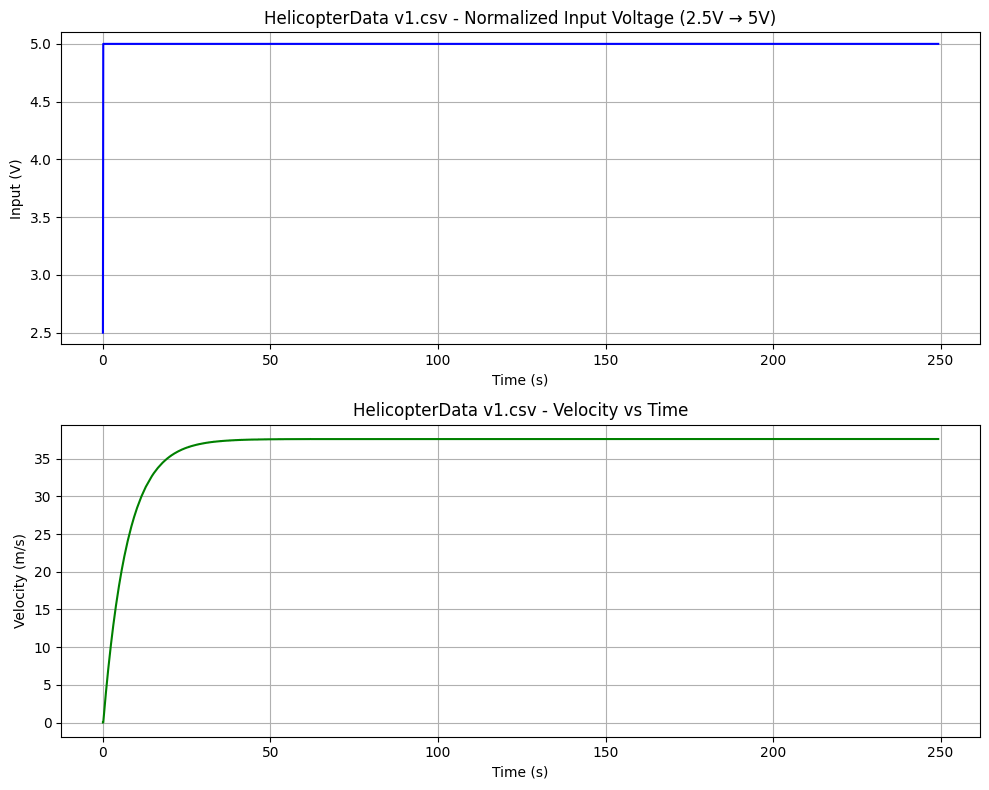

HelicopterData v1.csv:
  System Gain (A) = 15.0440 (m/s per V)
  Time Constant (τ) = 7.3000 s



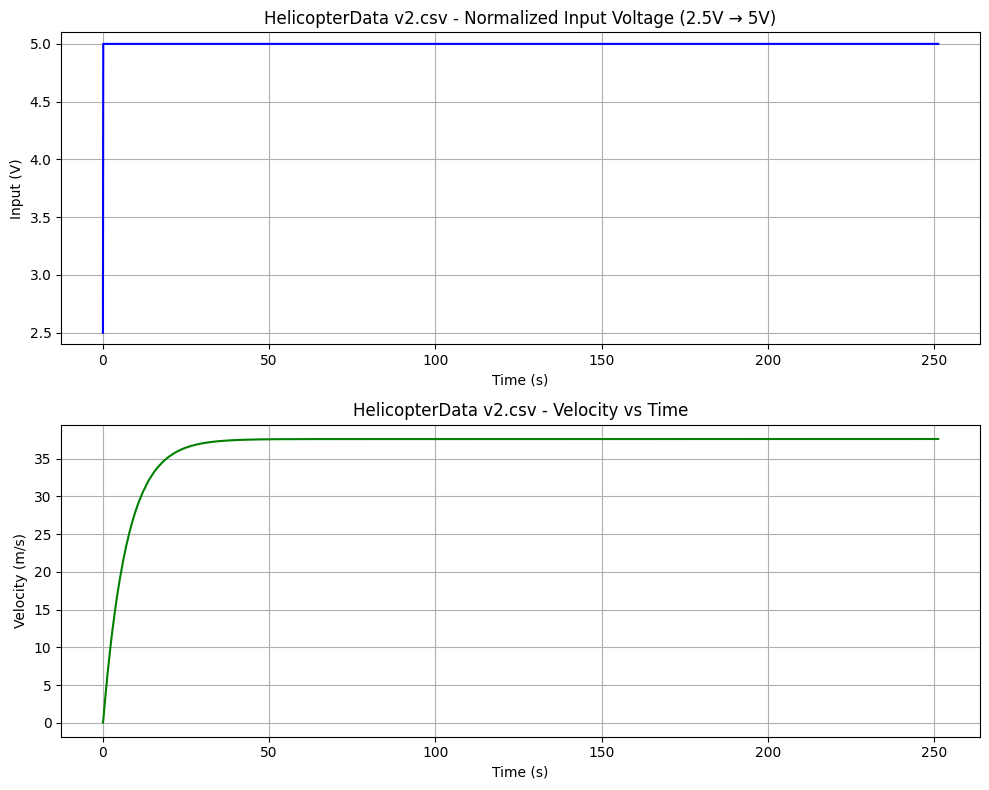

HelicopterData v2.csv:
  System Gain (A) = 15.0240 (m/s per V)
  Time Constant (τ) = 7.2000 s



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV files
files = ["HelicopterData v0.csv", "HelicopterData v1.csv", "HelicopterData v2.csv"]

def process_file(file_path):
    df = pd.read_csv(file_path)

    # --- Calculate velocity ---
    delta_position = df['Output(m)'].diff()
    delta_time = df['Time(s)'].diff()
    df['Velocity'] = delta_position / delta_time
    df['Velocity'] = df['Velocity'].fillna(0)

    # --- Find where the input step begins ---
    step_start_idx = df['Input(v)'].diff().abs().gt(0.05).idxmax()
    df = df.loc[step_start_idx:].reset_index(drop=True)

    # --- Re-shift time so it starts at 0 ---
    df['Time(s)'] = df['Time(s)'] - df['Time(s)'].iloc[0]

    # --- Normalize input: always 2.5 → 5 V ---
    min_val = df['Input(v)'].iloc[0]
    max_val = df['Input(v)'].max()
    if max_val > min_val:
        df['Input(v)'] = 2.5 + (df['Input(v)'] - min_val) * (2.5 / (max_val - min_val))
    else:
        df['Input(v)'] = 2.5  # flat line if no step

    return df

# --- Generate plots and compute gain + tau ---
for file in files:
    df = process_file(file)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Input vs Time
    axs[0].plot(df['Time(s)'], df['Input(v)'], color='blue')
    axs[0].set_title(f'{file} - Normalized Input Voltage (2.5V → 5V)')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Input (V)')
    axs[0].set_ylim([2.4, 5.1])
    axs[0].grid(True)

    # Velocity vs Time
    axs[1].plot(df['Time(s)'], df['Velocity'], color='green')
    axs[1].set_title(f'{file} - Velocity vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # --- Gain calculation ---
    initial_val = df['Velocity'].iloc[0]
    final_val = df['Velocity'].iloc[-1]
    step_amplitude = 2.5
    A = (final_val - initial_val) / step_amplitude

    # --- Time constant τ calculation (63.2% rule) ---
    target_val = initial_val + 0.632 * (final_val - initial_val)
    try:
        t_tau = df.loc[df['Velocity'] >= target_val, 'Time(s)'].iloc[0]
    except IndexError:
        t_tau = float('nan')  # if never reaches target

    # --- Print results ---
    print(f"{file}:")
    print(f"  System Gain (A) = {A:.4f} (m/s per V)")
    print(f"  Time Constant (τ) = {t_tau:.4f} s\n")


---

## **Identification Results Summary & Sensor**

In [2]:
import pandas as pd
import numpy as np

# List of CSV files
files = ["HelicopterData v0.csv", "HelicopterData v1.csv", "HelicopterData v2.csv"]

def process_file(file_path):
    df = pd.read_csv(file_path)

    # --- Calculate velocity ---
    df['Velocity'] = df['Output(m)'].diff() / df['Time(s)'].diff()
    df['Velocity'] = df['Velocity'].fillna(0)

    # --- Find step start based on Input(v) ---
    step_change = df['Input(v)'].diff().abs()
    if step_change.gt(0.05).any():
        step_start_idx = step_change.gt(0.05).idxmax()
    else:
        step_start_idx = 0
    df = df.loc[step_start_idx:].reset_index(drop=True)

    # --- Re-shift time ---
    df['Time(s)'] = df['Time(s)'] - df['Time(s)'].iloc[0]

    return df

# --- Store results ---
results = []

for file in files:
    df = process_file(file)

    # --- System Gain (A) ---
    initial_val = df['Velocity'].iloc[0]
    final_val = df['Velocity'].iloc[-1]
    step_amplitude = 2.5  # Input step size in volts
    A = (final_val - initial_val) / step_amplitude

    # --- Time constant τ (63.2% rule) ---
    target_val = initial_val + 0.632 * (final_val - initial_val)
    try:
        t_tau = df.loc[df['Velocity'] >= target_val, 'Time(s)'].iloc[0]
    except IndexError:
        t_tau = float('nan')

    # --- Sensor coefficient k_s ---
    # Use last value before saturation or maximum Output(v)
    mask = df['Output(v)'] < df['Output(v)'].max()  # before voltage saturation
    if mask.any():
        V_ss = df.loc[mask, 'Output(v)'].iloc[-1]
        y_ss = df.loc[mask, 'Output(m)'].iloc[-1]
    else:
        V_ss = df['Output(v)'].iloc[-1]
        y_ss = df['Output(m)'].iloc[-1]

    k_s = V_ss / y_ss if y_ss != 0 else float('nan')

    results.append({
        'Trial': file,
        'System Gain (A) (m/s per V)': round(A, 4),
        'Time Constant (τ) (s)': round(t_tau, 4),
        'Sensor coefficient k_s (V/m)': round(k_s, 2)  # rounding to 0.94 scale
    })

    print(f"{file}:")
    print(f"  System Gain (A) = {A:.4f} (m/s per V)")
    print(f"  Time Constant (τ) = {t_tau:.4f} s")
    print(f"  Sensor coefficient (k_s) = {k_s:.2f} V/m\n")

# --- Summary Table ---
results_df = pd.DataFrame(results)
print("Summary Table:")
print(results_df.to_string(index=False))

# --- Compute average sensor coefficient ---
avg_k_s = results_df['Sensor coefficient k_s (V/m)'].mean()
print(f"\nAverage sensor coefficient k_s across trials = {avg_k_s:.2f} V/m")


HelicopterData v0.csv:
  System Gain (A) = 15.0440 (m/s per V)
  Time Constant (τ) = 7.3000 s
  Sensor coefficient (k_s) = 0.98 V/m

HelicopterData v1.csv:
  System Gain (A) = 15.0440 (m/s per V)
  Time Constant (τ) = 7.3000 s
  Sensor coefficient (k_s) = 0.98 V/m

HelicopterData v2.csv:
  System Gain (A) = 15.0240 (m/s per V)
  Time Constant (τ) = 7.2000 s
  Sensor coefficient (k_s) = 0.98 V/m

Summary Table:
                Trial  System Gain (A) (m/s per V)  Time Constant (τ) (s)  Sensor coefficient k_s (V/m)
HelicopterData v0.csv                       15.044                    7.3                          0.98
HelicopterData v1.csv                       15.044                    7.3                          0.98
HelicopterData v2.csv                       15.024                    7.2                          0.98

Average sensor coefficient k_s across trials = 0.98 V/m


---

## **Model Validation**

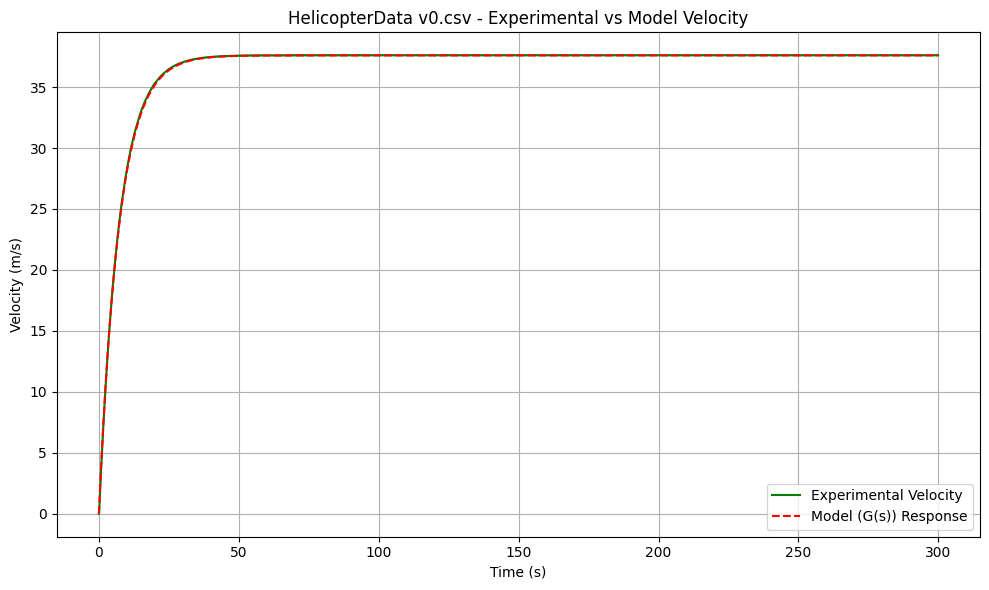

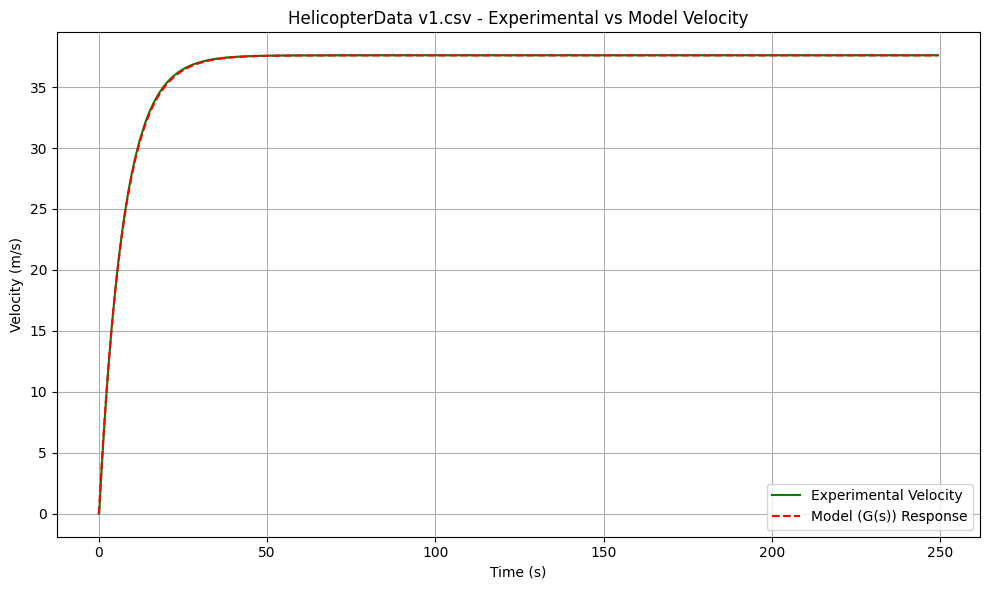

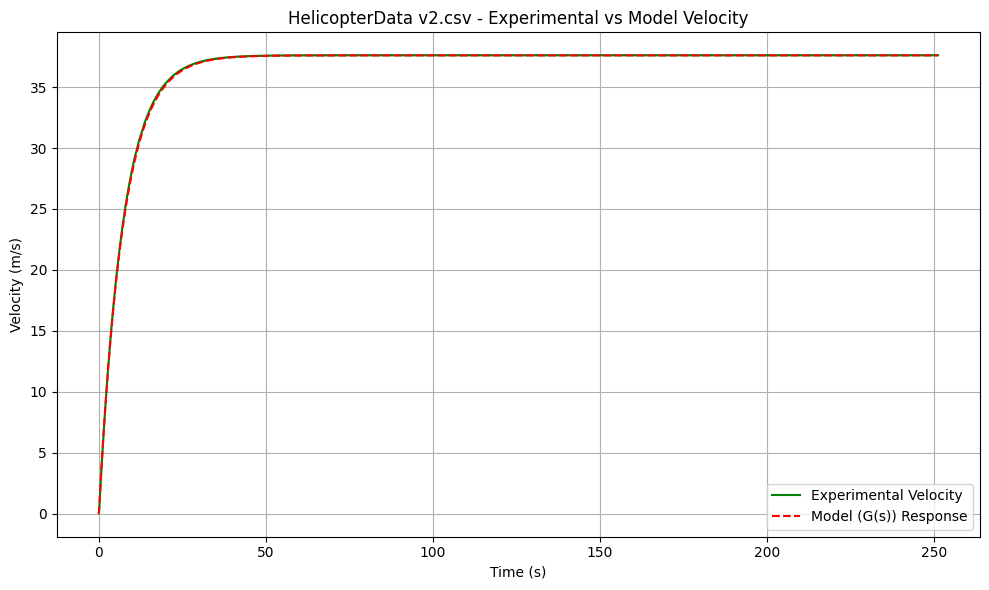

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import control as ctl

# List of CSV files
files = ["HelicopterData v0.csv", "HelicopterData v1.csv", "HelicopterData v2.csv"]

# Averaged transfer function G(s) = 15.04 / (7.3s + 1)
num = [15.04]
den = [7.3, 1]
system = ctl.tf(num, den)

def process_file(file_path):
    df = pd.read_csv(file_path)

    # --- Calculate velocity ---
    delta_position = df['Output(m)'].diff()
    delta_time = df['Time(s)'].diff()
    df['Velocity'] = delta_position / delta_time
    df['Velocity'] = df['Velocity'].fillna(0)

    # --- Find where the input step begins ---
    step_start_idx = df['Input(v)'].diff().abs().gt(0.05).idxmax()
    df = df.loc[step_start_idx:].reset_index(drop=True)

    # --- Re-shift time so it starts at 0 ---
    df['Time(s)'] = df['Time(s)'] - df['Time(s)'].iloc[0]

    # Normalize input (scale to 2.5 → 5 V)
    min_val = df['Input(v)'].iloc[0]
    max_val = df['Input(v)'].max()
    if max_val > min_val:
        df['Input(v)'] = 2.5 + (df['Input(v)'] - min_val) * (2.5 / (max_val - min_val))
    else:
        df['Input(v)'] = 2.5

    return df

# --- Plot experimental vs model velocity ---
for file in files:
    df = process_file(file)

    # Time vector for simulation
    t = df['Time(s)'].values
    u = np.ones_like(t) * 2.5  # step of amplitude 2.5
    _, y_model = ctl.forced_response(system, T=t, U=u)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time(s)'], df['Velocity'], label="Experimental Velocity", color="green")
    plt.plot(t, y_model, label="Model (G(s)) Response", color="red", linestyle="--")
    plt.title(f"{file} - Experimental vs Model Velocity")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
